In [3]:
import numpy as np
from sklearn.cluster import MeanShift
import utm
from sklearn.cluster import MeanShift
import statistics 
from statistics import mode 
import json
import requests
import time
import os
import geocoder
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
%matplotlib inline

In [10]:
#Make sure dt
def lambda_handler(b1 = 50, b2 = 150, p = 250):
    with open('data_ver3.json') as json_data:
        
        data = json.load(json_data)['data']
        array = []
        # Creating image array which contains all the images
        data_array = []
        # Creating a cordinate array which contains all the coordinates
        cordinate_array = []

        zone_array = []

        #add magnetic declination adjustment in College Station = 2.85°, in Houston = 2.28°
        
        for d in data:
            ut_cordinates = utm.from_latlon(d['latitude'], d['longitude'])
            t_list = [ut_cordinates[0],ut_cordinates[1],d['compass']+2.28]
            data_array.append(d)
            cordinate_array.append(ut_cordinates[2])
            zone_array.append(ut_cordinates[3])
            array.append(t_list)
        array = np.array(array)
        data_array = np.array(data_array)
        cordinate_array = np.array(cordinate_array)
        zone_array = np.array(zone_array)
        
        
        # Now the array will have latitude, longitude and compass as its columns
        X = array[:,[0,1]]
        # Now X will have only latitude and longitude values. Performing mean shift algorithm on the latitude and longitudes
        ms = MeanShift(bandwidth=b1)
        labels = ms.fit_predict(X)
        cluster_centers = ms.cluster_centers_
        labels = np.vstack(labels)

        array = np.hstack((array,labels))
        # Stacking the labels next to array. Now array contains latitude, longitude, compass, label
        
        return_value = []
        
        for cluster in range(len(cluster_centers)):
            
            current_cluster_result = {}
            indices_of_cluster = np.where(array[:,3] == cluster)
            # Here we take all the elements that belong to the current cluster and the indices are stored as indices_of cluster
            
            cluster_array = array[indices_of_cluster]  
            len_of_cluster = len(cluster_array)
            if len_of_cluster < 2:
                continue
                
            compass_array = cluster_array[:,[2]]
            a = np.tan(np.radians(90-compass_array))
            b = np.ones(np.shape(compass_array))
            c = np.multiply(a,cluster_array[:,[0]]) - cluster_array[:,[1]]
            eq_coeff_cluster = np.hstack((a, -b ,c))
            # we take the value of p as 300 just for analysing the time taken to run this
            # Creating lines from the compass and the current point
            p = p
                
            # Initializing the intersection of lines numpy array
            pairwise_indices = np.random.randint(0, len_of_cluster , (p,2))
            pairs = eq_coeff_cluster[pairwise_indices]
            
            A = pairs[:,:,:-1]
            Y = pairs[:,:,-1:]
            intersections_of_lines = np.squeeze(np.matmul(np.linalg.pinv(A),  Y))
            
            # Performing mean shift clustering and finding the cluster with the maximum number of points
            # This center point is taken as the estimated center of the object
            
            start = time.time()
            ms = MeanShift(bandwidth=b2)  
            labels = (ms.fit_predict(intersections_of_lines)).tolist()
            cluster_centers = ms.cluster_centers_
            end = time.time()
            
            mode_of_labels = max(set(labels), key=labels.count)
            current_cluster_result['cluster_id'] = cluster
            current_cluster_result['cluster_item_count'] = len_of_cluster
            
            cordinate_list = (cordinate_array[indices_of_cluster]).tolist()
            cordinate = max(set(cordinate_list), key=cordinate_list.count)
            
            zone_list = (zone_array[indices_of_cluster]).tolist()
            zone = max(set(zone_list), key=zone_list.count)
            lat_long = utm.to_latlon(cluster_centers[mode_of_labels][0], cluster_centers[mode_of_labels][1], cordinate, zone)
            
            current_cluster_result['cluster_latitude'] = lat_long[0]
            current_cluster_result['cluster_longitude'] = lat_long[1]
            current_cluster_result['cluster_objects'] = (data_array[indices_of_cluster]).tolist()

            return_value.append(current_cluster_result)
            
        return {
            "statusCode": 200,
            "body": {'objects': return_value}
        }
start = time.time()
lambda_handler()
end = time.time()
print((end-start)*1000)

3167.951822280884


In [7]:
def goodness(b1=50, b2=100, p=100):
    results = lambda_handler(b1=b1, b2=b2,p=p)['body']['objects']
    cluster_centers = [[cluster['cluster_latitude'], cluster['cluster_longitude']]for cluster in results]
    cluster_centers = np.array(cluster_centers)
    
    json_data = open('data_ver3.json') 
    data = json.load(json_data)['data']
    collected_data = [[d['latitude'], d['longitude']] for d in data]
    collected_data = np.array(collected_data)
    json_data.close()
    
    true_data = [[29.70154390339952, -95.39209601022654],[29.70428338419638, -95.39100648039813], [29.703335743447496, -95.39130824050142], [29.702188761458533, -95.3936918414558], [29.702691697389692, -95.39530032710667], [29.703085520490866, -95.39629883360872], [29.722233773075338, -95.36705220231357],[29.72526628586194, -95.37240452291601], [29.72734309820575, -95.375255487577], [29.728189612898646, -95.37701142524726],[29.729725295675568, -95.38003134004325], [29.73117267948174, -95.38260255498517],[29.731857687219605, -95.38404510951365],[29.756970123575087, -95.37525775033865], [29.7552538566023, -95.37571750526642],[29.755200480497276, -95.3794874504529],[29.75464650875399, -95.38024579642178],[29.754603020003177, -95.38300456681712],[29.752629019819906, -95.38306070220811], [29.752095895517666, -95.38491481879633]]
    true_data = np.array(true_data)
    
    return collected_data, cluster_centers, true_data


In [12]:
def find_Error(b1, b2, p, print_data = True):
    collected_data, cluster_centers, true_data = goodness(b1, b2, p)
    radians_in_m = 6371000
    result = haversine_distances(np.radians(true_data), np.radians(cluster_centers)) * radians_in_m
    min_distances = result.min(axis=1)

    new_cluster_center = cluster_centers[np.argmin(result, axis=1)]
    mean = min_distances.mean()
    maxim = min_distances.max()
    if print_data:
        print(min_distances)
        print("Mean error is {}m".format(mean))
        print("Maximum error is {}m".format(maxim))
    return mean, maxim

find_Error(50,100,100)

[ 3.28945827  1.64553149  1.79561467  9.89023797  5.55574115  4.5762624
  2.86805439  0.98266886  4.22234964  6.15877341  4.49908249 12.08479072
  1.83619001  6.03581563  5.37632299  3.45731088  3.84873669  4.69809211
  0.54194875  1.02391525]
Mean error is 4.2193448880646764m
Maximum error is 12.084790715831167m


(4.2193448880646764, 12.084790715831167)

In [ ]:
def plot_variation():
    mean_array = []
    maxim_array = []
    for i in tqdm(range(20)):
        mean, maxim = find_Error(50, 100, 100, print_data=False)
        mean_array.append(mean)
        maxim_array.append(maxim)
    fig = plt.figure(0)
    plt.plot(np.arange(20), mean_array, 'r-', label="Mean Error")
    plt.plot(np.arange(20), maxim_array, 'b--', label="Maximum Error")
    plt.xlabel("Number of iterations")
    plt.ylabel("Distance in meters")
    plt.legend()
    plt.savefig('single_parameter_variations.png')
    plt.show()
    print("Mean error of 20 iterations is {}".format(np.array(mean_array).mean()))
    print("Mean max error of 20 iterations is {}".format(np.array(maxim_array).mean()))
plot_variation()

In [9]:
def plot_variation_in_bandwidths():
    bandwidths = [100, 150, 200, 250, 300]
    mean_array=[]
    maxim_array=[]
    for b2 in tqdm(bandwidths):
        mean, maxim = find_Error(cluster_centers, true_data, 50, b2,300, print_data=False)
        mean_array.append(mean)
        maxim_array.append(maxim)
    fig = plt.figure(1)   
    plt.plot(bandwidths, mean_array, 'r-', label="Mean Error")
    plt.plot(bandwidths, maxim_array, 'b--', label="Maximum Error")
    plt.xlabel("Bandwidth")
    plt.ylabel("Distance in meters")
    plt.legend()
    plt.savefig('single_parameter_variations_b2.png')
    plt.show()
plot_variation_in_bandwidths()

  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'cluster_centers' is not defined





  0%|          | 0/6 [00:00<?, ?it/s]



 17%|█▋        | 1/6 [00:10<00:52, 10.45s/it]



 33%|███▎      | 2/6 [00:25<00:46, 11.75s/it]



 50%|█████     | 3/6 [00:37<00:36, 12.03s/it]



 67%|██████▋   | 4/6 [00:52<00:25, 12.78s/it]



 83%|████████▎ | 5/6 [01:08<00:13, 13.66s/it]



100%|██████████| 6/6 [01:25<00:00, 14.20s/it]


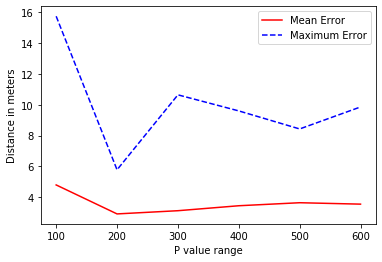

<Figure size 432x288 with 0 Axes>

In [130]:
def plot_variation_in_p():
    p_values = [100, 200, 300, 400, 500, 600]
    mean_array=[]
    maxim_array=[]
    for p in tqdm(p_values):
        mean, maxim = find_Error(cluster_centers, true_data, 50, 150, p, print_data=False)
        mean_array.append(mean)
        maxim_array.append(maxim)
    
    figure = plt.figure()
    plt.plot(p_values, mean_array, 'r-', label="Mean Error")
    plt.plot(p_values, maxim_array, 'b--', label="Maximum Error")
    plt.xlabel("P value range")
    plt.ylabel("Distance in meters")
    plt.legend()
    plt.show()
    plt.savefig('single_parameter_variations_p.png')
    
    
plot_variation_in_p()